In [524]:
#G050.2213-00.6063
#19:25:57.52 15:03:00.3
#3.3 kpc
#Band 6 ALMA
#CH3OH (methanol)

In [525]:
# For Colab
!pip install peakutils
!pip install lineid_plot
!pip install astroquery
!pip install lmfit
!wget https://raw.githubusercontent.com/saint-germain/rot_diag/main/SDC24.381-0.21_3.csv

--2024-03-27 23:47:19--  https://raw.githubusercontent.com/saint-germain/rot_diag/main/SDC24.381-0.21_3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 417924 (408K) [text/plain]
Saving to: ‘SDC24.381-0.21_3.csv.1’

SDC24.381-0.21_3.cs 100%[===================>] 408.13K  --.-KB/s    in 0.005s  

2024-03-27 23:47:19 (82.1 MB/s) - ‘SDC24.381-0.21_3.csv.1’ saved [417924/417924]



In [526]:
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import astropy.constants as c
import peakutils
from peakutils.plot import plot as pplot
import matplotlib.pyplot as plt
import pandas as pd
import lineid_plot
from lmfit.models import GaussianModel
import numpy as np
from scipy.optimize import curve_fit


In [527]:
min_frequency=241.67
max_frequency=241.91
response = CDMS.query_lines(min_frequency= min_frequency* u.GHz,
                            max_frequency=max_frequency * u.GHz,
                            molecule="032504 CH3OH, vt=0-2",
                            get_query_payload=False,temperature_for_intensity=0)


In [528]:
# remove duplicates?
#dlist=response['ELO']
#selec=[s for (i, v),s in zip(enumerate(dlist),range(len(dlist))) if i == 0 or v != dlist[i-1]]
#response=response[selec]

In [529]:
line_wave=response['FREQ']/1e3 # MHz to GHz
line_label=[str(i) for i in line_wave] # line label for plotting

In [530]:
fname='SDC24.381-0.21_3.csv'
df = pd.read_csv(fname)
freq=df['Freq']
flux=df['Flux']

In [531]:
spe=np.loadtxt('spectra_norm_41sources.txt',delimiter=',')
names=pd.read_csv('PCA_results_All41 copy.csv').source

'G050.2213-00.6063'

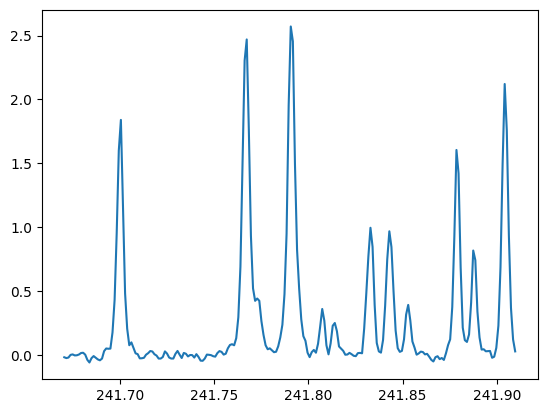

In [534]:
mix=7
t_b=spe[mix][:-1] #25 ftw # 7 (13,15)
filter=(freq>min_frequency)&(freq<max_frequency)
freqn=freq[filter]
t_bn=flux[filter]
plt.plot(freqn,t_bn*1.8/.7)
names[mix]

In [535]:
flux=8e11*t_b*(freq/240)**2

(<Figure size 3000x1500 with 1 Axes>, <Axes: >)

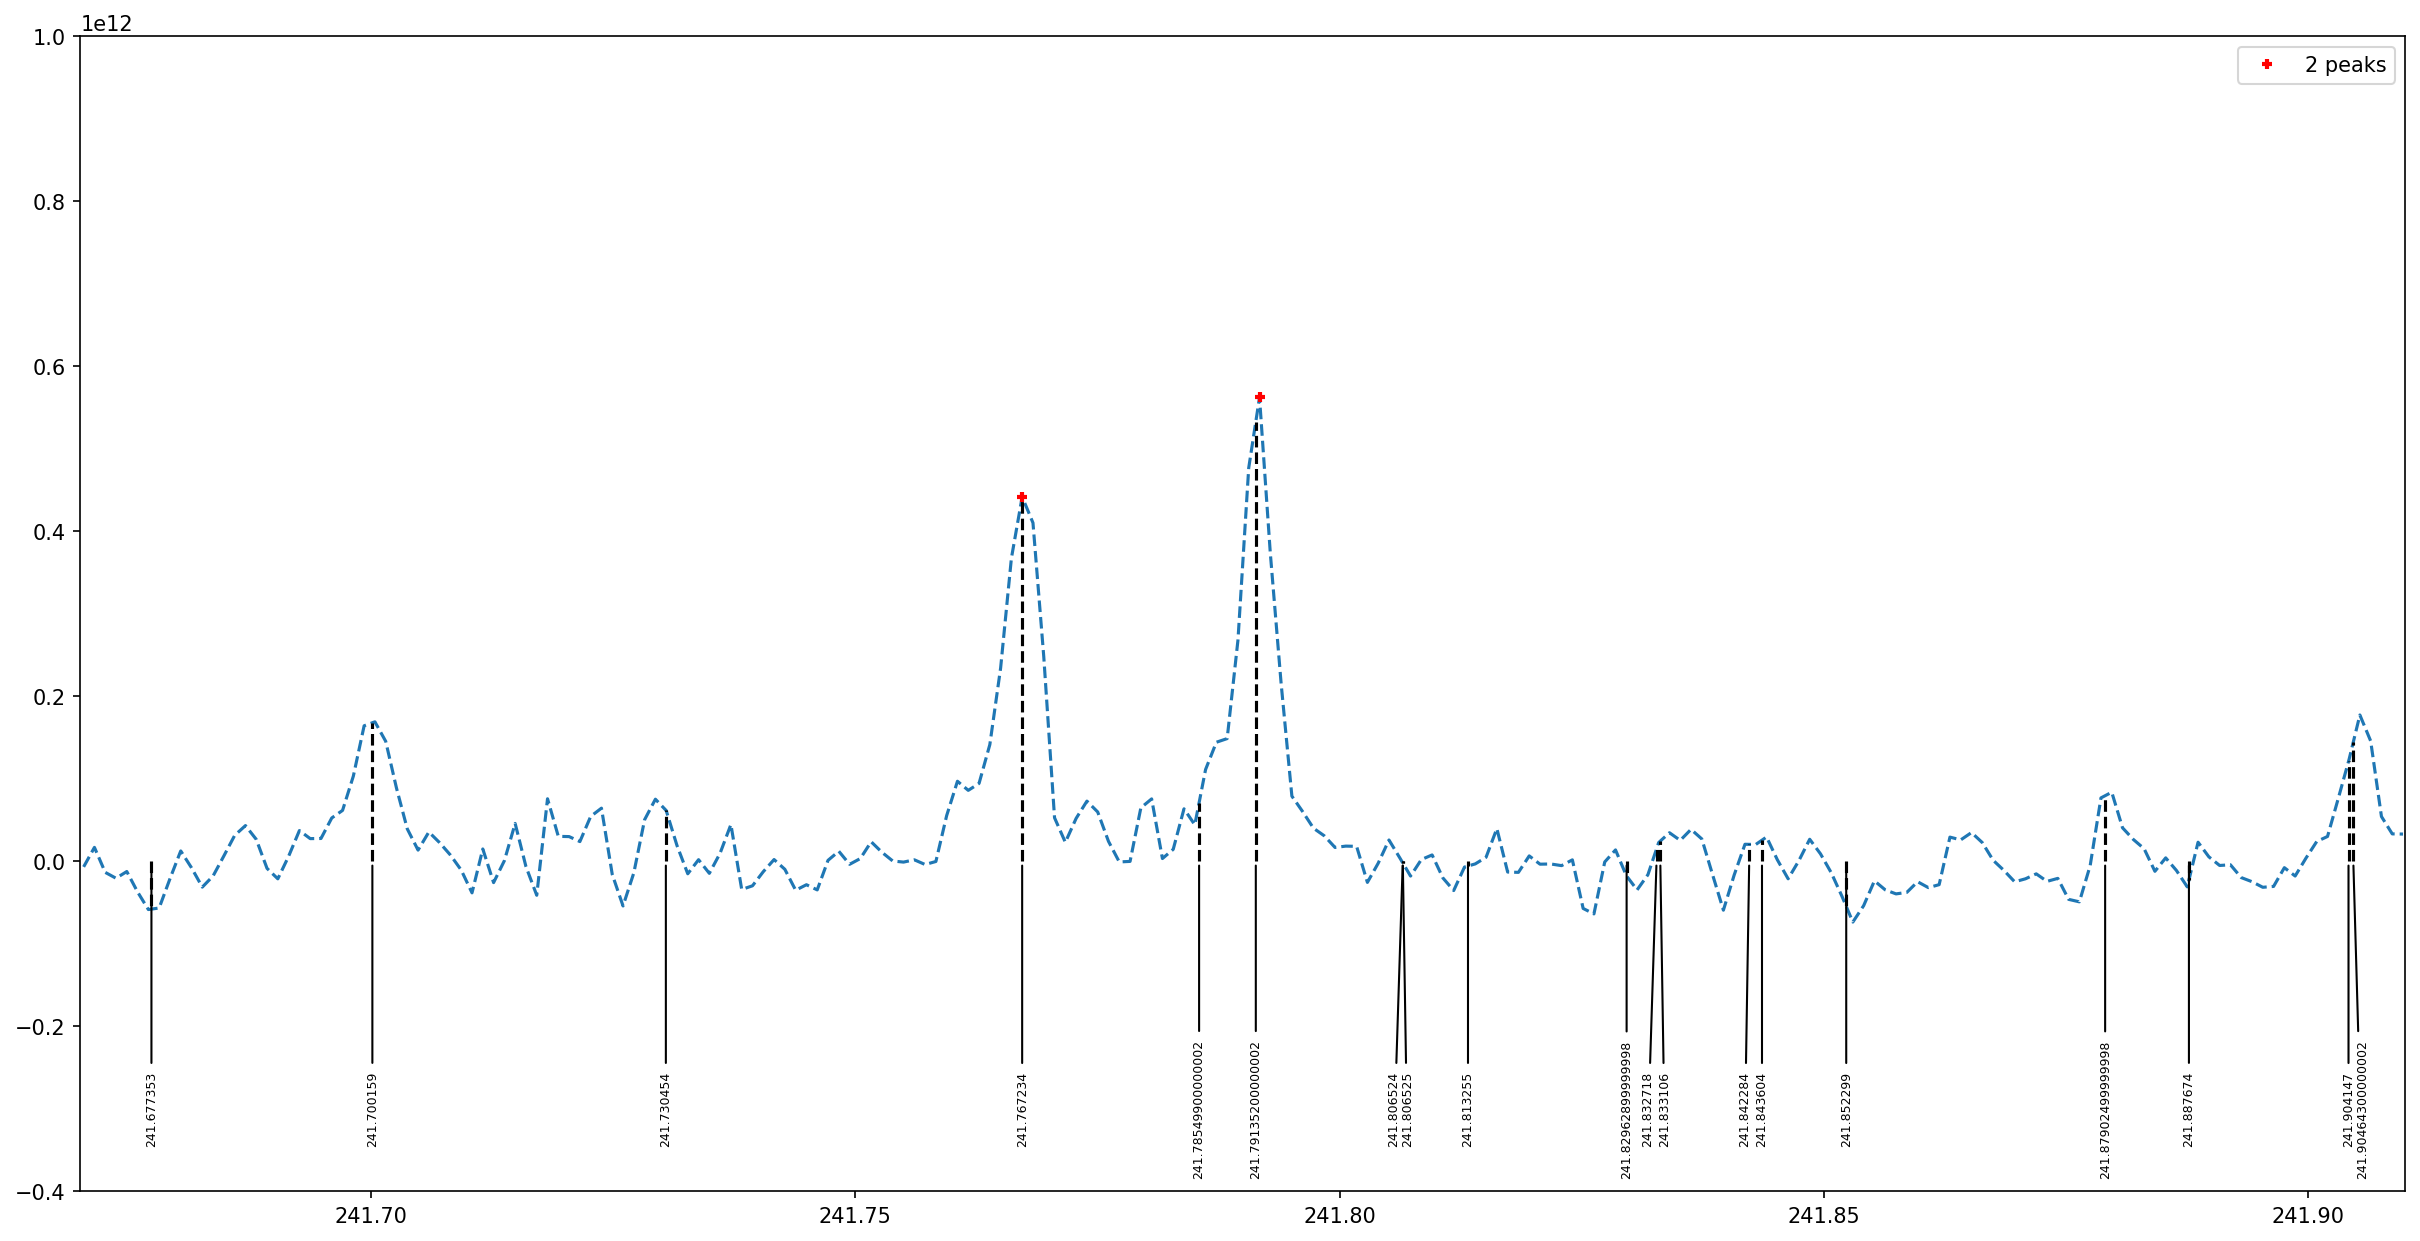

In [541]:
# plot cropped spectrum + plausible line locations
filter=(freq>min_frequency)&(freq<max_frequency)
freqn=freq[filter]
fluxn=flux[filter]

indices = peakutils.indexes(fluxn, thres=0.400, min_dist=0.1)  # indices son las 'posiciones' de los picos
fig, ax = plt.subplots(figsize=(20,10),dpi=150)

pplot(freqn, fluxn, indices)
ax.set_xlim(min_frequency,max_frequency)
ax.set_ylim(-4e11,1e12)
lineid_plot.plot_line_ids(freqn, fluxn, line_wave, line_label, ax=ax, arrow_tip=0, box_loc=-3e11, max_iter=300, label1_size=6)

In [572]:
# gaussian model for each plausible line
for i,j in zip(line_wave,range(len(line_wave))):
  gausstemp=GaussianModel(prefix='g'+str(j)+'_')

npeaks=len(line_wave)
model=GaussianModel(prefix='g1_')
for i in range(1,npeaks):
  model=model+GaussianModel(prefix='g%d_' % (i+1))
pars=model.make_params()
for i,ff in zip(range(npeaks),line_wave):
  pars['g%d_center' % (i+1)].set(value=ff,vary=False) # fix nu_ul
  pars['g%d_sigma' % (i+1)].set(value=0.01, min=1e-3,max=0.02)
  pars['g%d_amplitude' % (i+1)].set(value=0.01, min=0,max=5e14)

In [573]:
out=model.fit(fluxn,pars,x=freqn) # run fitting algorithm
comps = out.eval_components(x=freqn) # fit results for each line

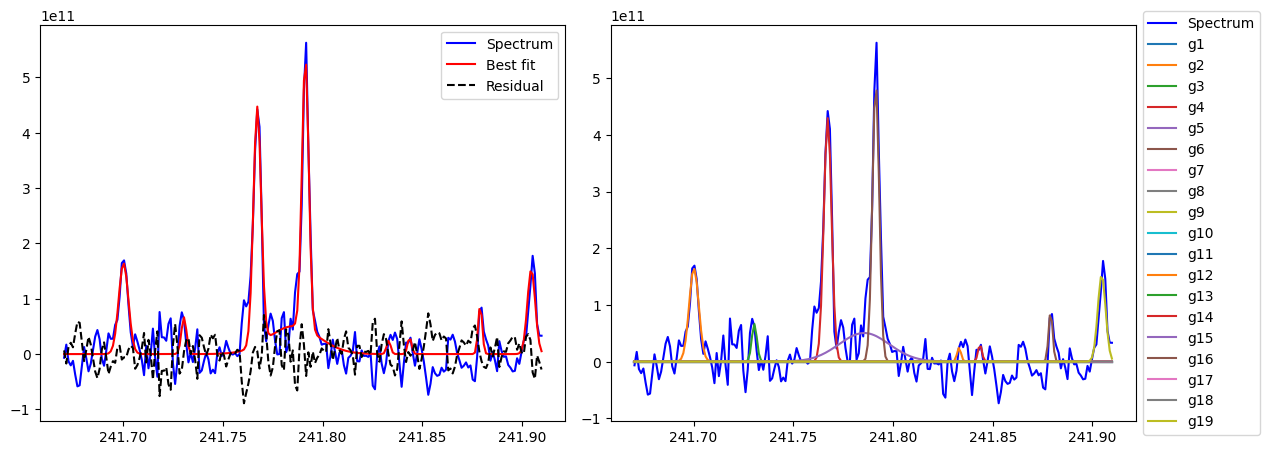

In [574]:
# plot left: data,model,residuals
# plot right: plot each line fit
x=freqn
y=fluxn

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y, 'b',label='Spectrum')
axes[0].plot(x, out.best_fit, 'r-', label='Best fit')
axes[0].plot(x, out.residual, 'k--', label='Residual')
axes[0].legend(loc='best')

axes[1].plot(x, y, 'b',label='Spectrum')
for i in range(npeaks):
  axes[1].plot(x, comps['g%d_' % (i+1)], label='g'+str(i+1))

axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.tight_layout()

In [575]:
# save line parameters:
# frequency, eup, aul, gup, i dnu integral
# GHz, K, s^-1, N/A, Jy*sr^-1*Hz
elo=response['ELO']*1.43*u.K*u.cm # cm**-1 to K
etrans=line_wave*0.04799*u.K/u.MHz # GHz**-1 to K
eup=elo+etrans

Aul=10**response['LGAIJ']
gup=response['GUP']

dnu=freqn.iloc[1]-freqn.iloc[0]
integ_txt=[np.trapz(comps['g%d_'%(i+1)],dx=dnu) for i in range(npeaks)]

mydict={'Freq':line_wave,'Eup':eup,'Aul':Aul,'gup':gup,'I dv':integ_txt}
df_txt = pd.DataFrame(mydict)
df_txt.to_csv('line_parameters.csv', index=False)

In [576]:
# eup < 500 K; log > 0
# end of hints
# use curve_fit to fit

In [577]:
inte=np.array(df_txt['I dv'])*u.Jy*u.GHz
ff=np.array(df_txt['Freq'])*u.GHz
aul=np.array(df_txt['Aul'])/(1*u.s)
NU=((4*np.pi*inte)/(c.h*ff*aul)).cgs
yy=np.log(NU*u.cm**2/df_txt['gup'])
xx=df_txt['Eup']

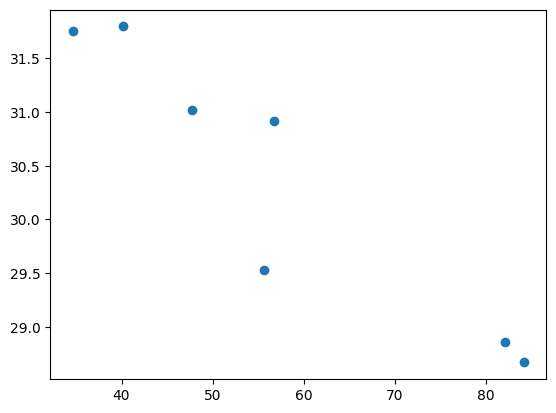

In [579]:
filter2=(df_txt['Eup']<500)&(np.log(NU*u.cm**2/df_txt['gup'])>26)
plt.scatter(xx[filter2],yy[filter2])

Fitted parameters:
m: -0.064349660774236
c: 34.052578062431074


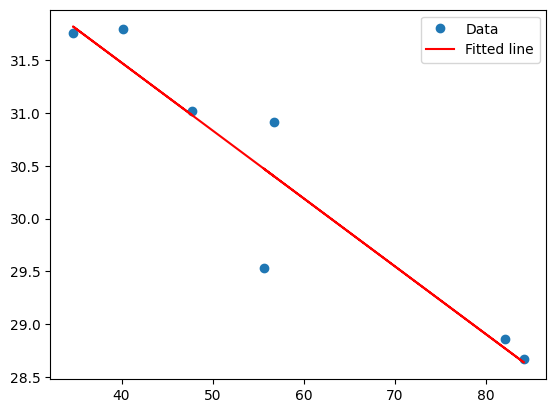

In [580]:
from scipy.optimize import curve_fit
def straight_line(x, m, c):
    return m * x + c

popt, pcov = curve_fit(straight_line, xx[filter2], yy[filter2])

# Plot the data and the fitted line
plt.plot(xx[filter2], yy[filter2], 'o', label="Data")
plt.plot(xx[filter2], straight_line(xx[filter2], *popt), 'r-', label="Fitted line")

# Print the fitted parameters
print("Fitted parameters:")
print("m:", popt[0])
print("c:", popt[1])

# Show the plot
plt.legend()
plt.show()


In [581]:
tfit=-1/popt[0]
tfit

15.540097460783741

In [582]:
# partition function
result = CDMS.get_species_table()
mol = result[result['tag'] == 32504]
mol.pprint(max_width=160)

 tag     molecule   #lines lg(Q(1000)) lg(Q(500)) lg(Q(300)) lg(Q(225)) lg(Q(150)) lg(Q(75)) lg(Q(37.5)) lg(Q(18.75)) lg(Q(9.375)) lg(Q(5.000)) lg(Q(2.725))
----- ------------- ------ ----------- ---------- ---------- ---------- ---------- --------- ----------- ------------ ------------ ------------ ------------
32504 CH3OH, vt=0-2  38643      5.5413     5.0092     4.5685      4.322      3.989     3.466      2.9642       2.4393       1.8931       1.4268       1.0752


[4.70233579]


Text(0, 0.5, 'Partition Function')

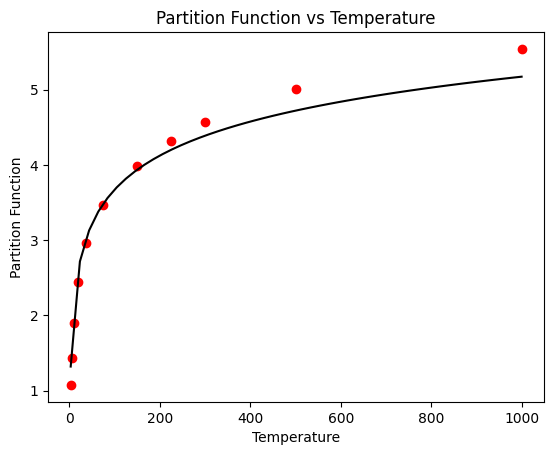

In [583]:
def f(T, a):
        return np.log10(a*T**(1.5))
keys = [k for k in mol.keys() if 'lg' in k]
def tryfloat(x):
    try:
       return float(x)
    except:
       return np.nan
temp = np.array([float(k.split('(')[-1].split(')')[0]) for k in keys])
part = np.array([tryfloat(x) for x in mol[keys][0]])
param, cov = curve_fit(f, temp[np.isfinite(part)], part[np.isfinite(part)])
print(param)
x = np.linspace(2.7,1000)
y = f(x,param[0])
plt.scatter(temp,part,c='r')
plt.plot(x,y,'k')
plt.title('Partition Function vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Partition Function')

In [584]:
f(tfit,param[0])*np.exp(popt[1])

1512490160110844.8

In [585]:
1.5e15

1500000000000000.0

In [586]:
f(tfit,param[0])*np.exp(popt[1])/1e15

1.5124901601108447

In [594]:
(pd.DataFrame({'Freq':np.array(freq),'Intensity':np.array(flux)})).to_csv(names[mix]+'.csv', index=False)